準備

In [ ]:
!tar -xvf dataset.tar

ファインチューニング

In [ ]:
import os
import math
import tensorflow as tf
import numpy as np
import cv2
import tqdm
import glob

from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
# メトリック層定義
class MetricLayer(tf.keras.layers.Layer):
    def __init__(self, num_classes, margin=0.5, logist_scale=64, **kwargs):
        super(MetricLayer, self).__init__(**kwargs)
        self.num_classes = num_classes
        self.margin = margin
        self.logist_scale = logist_scale

    def build(self, input_shape):
        self.w = self.add_variable(
            "weights", shape=[int(input_shape[-1]), self.num_classes])
        self.cos_m = tf.identity(math.cos(self.margin), name='cos_m')
        self.sin_m = tf.identity(math.sin(self.margin), name='sin_m')
        self.th = tf.identity(math.cos(math.pi - self.margin), name='th')
        self.mm = tf.multiply(self.sin_m, self.margin, name='mm')

    def call(self, embds, labels):
        normed_embds = tf.nn.l2_normalize(embds, axis=1, name='normed_embd')
        normed_w = tf.nn.l2_normalize(self.w, axis=0, name='normed_weights')

        cos_t = tf.matmul(normed_embds, normed_w, name='cos_t')
        sin_t = tf.sqrt(1. - cos_t ** 2, name='sin_t')

        cos_mt = tf.subtract(
            cos_t * self.cos_m, sin_t * self.sin_m, name='cos_mt')

        cos_mt = tf.where(cos_t > self.th, cos_mt, cos_t - self.mm)

        mask = tf.one_hot(tf.cast(labels, tf.int32), depth=self.num_classes,
                          name='one_hot_mask')

        logists = tf.where(mask == 1., cos_mt, cos_t)
        logists = tf.multiply(logists, self.logist_scale, 'arcface_logist')

        return logists


In [ ]:
# 訓練用データ読み込み関数
def read_data(dataset_path='./train'):
    samples = []
    labels = []
    num_class = 0
    for id_name in tqdm.tqdm(os.listdir(dataset_path)):
        img_paths = glob.glob(os.path.join(dataset_path, id_name, '*.jpg'))
        for img_path in img_paths:
            img = cv2.imread(img_path)
            img = cv2.resize(img, (112, 112))
            img = img.astype(np.float32) / 255.
            samples.append(img)
            labels.append(int(id_name))
        num_class = num_class + 1
    return np.array(samples), np.array(labels), num_class

In [ ]:
# バッチサイズ設定
BATCH_SIZE = 8

# データセット読み込み
x_train, y_train, num_class = read_data('./dataset/train')

# 特徴量抽出モデル構築
model_input = Input([112, 112, 3], name='input_image')

mobilenetv2 = MobileNetV2(input_shape=model_input.shape[1:],
                          include_top=False,
                          weights='imagenet')
feature_extractor = mobilenetv2(model_input)

flatten_layer = Flatten()
feature_extractor = flatten_layer(feature_extractor)

dense_layer = Dense(512, kernel_regularizer=tf.keras.regularizers.l2(5e-4))
feature_extractor = dense_layer(feature_extractor)

# メトリック層
labels = Input([], name='label')
logist_inputs = Input(feature_extractor.shape[1:])
labels_input = Input(labels.shape[1:])
metric_layer = MetricLayer(num_classes=num_class,
                           margin=0.5,
                           logist_scale=64)
metric_layer = metric_layer(logist_inputs, labels_input)

# 出力層
logist = Model((logist_inputs, labels_input), metric_layer)

logist = logist((feature_extractor, labels))

# モデル構築
model = Model((model_input, labels), logist, name='face_model')

model.summary()

100%|██████████| 5/5 [00:00<00:00, 78.92it/s]

Model: "face_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 112, 112, 3) 0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Functiona (None, 4, 4, 1280)   2257984     input_image[0][0]                
__________________________________________________________________________________________________
flatten (Flatten)               (None, 20480)        0           mobilenetv2_1.00_224[0][0]       
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          10486272    flatten[0][0]                    
_________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


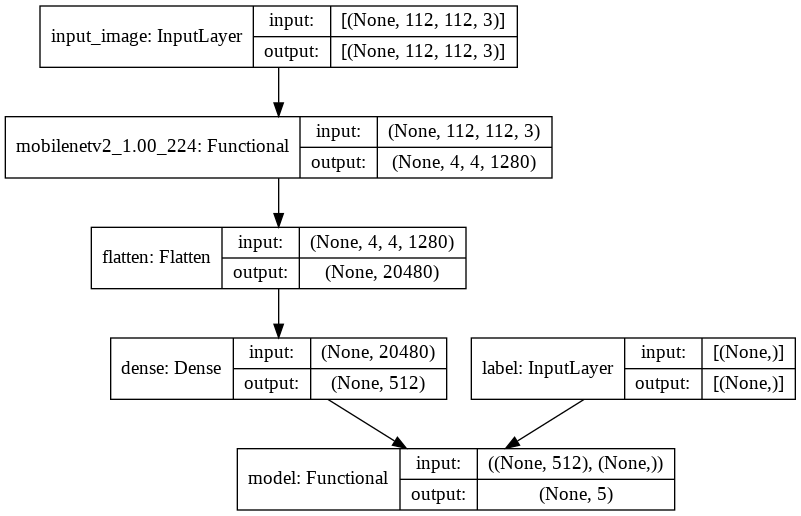

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# 最適化アルゴリズム設定
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.01, momentum=0.9, nesterov=True)

# 損失関数設定
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# モデルコンパイル
model.compile(optimizer=optimizer, loss=loss_fn)

# コールバック設定
mc_callback = ModelCheckpoint(
    'checkpoints/' + 'e_{epoch}.ckpt',
    save_weights_only=True)
tb_callback = TensorBoard(log_dir='logs/',
                          histogram_freq=1)
lr_callback = ReduceLROnPlateau(monitor='loss',
                                factor=0.5,
                                patience=10,
                                verbose=1
                                )
callbacks = [mc_callback, tb_callback, lr_callback]

In [ ]:
# 訓練開始
model.fit((x_train, y_train),
          validation_split=0.2,
          epochs=20,
          batch_size=BATCH_SIZE,
          callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/20
5/5 [==============================] - 4s 462ms/step - loss: 0.4995 - val_loss: 0.4994
Epoch 2/20
5/5 [==============================] - 1s 264ms/step - loss: 0.4992 - val_loss: 0.4991


KeyboardInterrupt: ignored

In [ ]:
# モデルから特徴量抽出モデルのみ抜き出し
model = tf.keras.Model(inputs=model.input[0], outputs=model.layers[-3].output)

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 112, 112, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
flatten (Flatten)            (None, 20480)             0         
_________________________________________________________________
dense (Dense)                (None, 512)               10486272  
Total params: 12,744,256
Trainable params: 12,710,144
Non-trainable params: 34,112
_________________________________________________________________


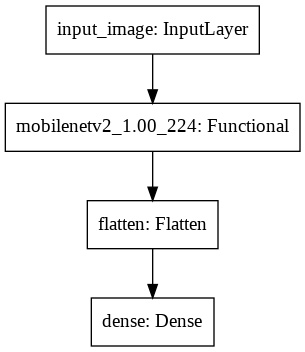

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
# モデル保存
model.save('face_model.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
